# DRAFT

# Prediction <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

## Description


### Load Packages

In [2]:
import sys
import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import subprocess as sp
from joblib import load
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
from sklearn.preprocessing import StandardScaler
from odc.algo import xr_geomedian, int_geomedian

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_spatialtools import xr_rasterize
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster
from deafrica_classificationtools import HiddenPrints
from deafrica_plotting import rgb, display_map, map_shapefile
from deafrica_classificationtools import HiddenPrints, predict_xr

import warnings
warnings.filterwarnings("ignore")


### Set up a dask cluster
This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:41837 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 31 Memory: 254.70 GB


## Analysis parameters

* `model_path`: The path to the location where the model exported from the previous notebook is stored
* `training_data`: Name and location of the training data `.txt` file output from runnning `1_Extract_training_data.ipynb`
* `testing_locations`: A dictionary with values containing latitude and longitude points, and keys representing a unique ID to indetify the locations (these keys are used as filenames when exporting classifications as geotiffs).
* `buffer`: The number of degrees to load around the central latitude and longitude points in `locations`. This number here will depend on the compute/RAM available on the Sandbox instance, and the type and number of feature layers calculated. A value of `0.25` (which results in a 0.5 x 0.5 degree analysis extent) usually works well on the large sandbox instance.
* `results`: A folder location to store the classified geotiffs 

In [4]:
model_path = 'results/ml_model.joblib'

training_data = "results/training_data/test_training_data.txt"

testing_locations = {
    '1': (24.4780, 33.0457),
    '2': (22.7712, 28.5223),
    '3': (30.3971, 30.7996),
    '4': (31.1751, 31.2221),
}

buffer = 0.1

results = 'results/classifications/'

dask_chunks = {'x':1000,'y':1000,'time':1}

### Connect to the datacube

In [5]:
dc = datacube.Datacube(app='prediction')

## Open the model

The code below will also re-open the training data we exported from `2_Inspect_training_data.ipynb` and grab the column names (features we selected).

In [6]:
model = load(model_path)

In [7]:
# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[2:]
print(column_names)

['blue_S1', 'green_S1', 'red_S1', 'nir_S1', 'swir_1_S1', 'swir_2_S1', 'red_edge_1_S1', 'red_edge_2_S1', 'red_edge_3_S1', 'NDVI_S1', 'NDWI_S1', 'blue_S2', 'green_S2', 'red_S2', 'nir_S2', 'swir_1_S2', 'swir_2_S2', 'red_edge_1_S2', 'red_edge_2_S2', 'red_edge_3_S2', 'NDVI_S2', 'NDWI_S2', 'slope']


## Making a prediction


### 1. Redefining the feature layer function

How you define this function will depend on the steps you took in the previous notebooks.  If you elected to use the feature selection methods in `2_Inspect_training_data.ipynb` to reduce the number of features, then you may need to reconfigure the function to reduce the number of layers loaded (thereby reducing the time it takes to load and/or compute the feature layers). If you instead elected to use all the features extracted in `1_Extract_training_data.ipynb`, then you can simply copy-and-paste your `custom_training_data` function from the first notebook into the cell below.  

> **Note:** Because we are using dask to help us scale the operations, we need to add a .chunks() method to the `slope` layer so this layer will interact with the dask arrays in the satellite data. As slope is a 2D layer, we don't need 'time' in the chunks argument, only 'x' and 'y'.

In [8]:
from odc.algo import xr_geomedian
from datacube.testutils.io import rio_slurp_xarray

def two_seasons_gm(ds):
    #connect to datacube
    dc = datacube.Datacube(app='training')
    #normalise dataset 0-1
    ds = ds / 10000
    
    #split ds into 2 six month periods
    ds1 = ds.sel(time=slice('2019-01', '2019-06'))
    ds2 = ds.sel(time=slice('2019-07', '2019-12')) 
    
    def gm(ds, era):
        
        #geomedian and indices
        gm_ = xr_geomedian(ds)
        gm_ = calculate_indices(gm_,
                               index=['NDVI', 'NDWI'],
                               drop=False,
                               normalise=False,
                               collection='s2')
        
        #rename bands with suffix for each season
        for band in gm_.data_vars:
            gm_ = gm_.rename({band:band+era})
        
        return gm_
    
    epoch1 = gm(ds1, era='_S1')
    epoch2 = gm(ds2, era='_S2')
    
    #add slope dataset
    url_slope = "https://deafrica-data.s3.amazonaws.com/ancillary/dem-derivatives/cog_slope_africa.tif"
    slope = rio_slurp_xarray(url_slope, gbox=ds.geobox)
    slope = slope.to_dataset(name='slope')
    slope = slope.chunk({'x':1000,'y':1000}) #turn into dask arrays, must match dask chunks on ds
    
    #merge results into single dataset 
    result = xr.merge([epoch1,
                       epoch2,
                       slope],compat='override')
    
    # keep only the features we identified as useful
    # in the earlier notebooks
    result = result[column_names]

    return result.squeeze()

### 2. Set up datacube query

These query options should match the query params in `1_Extract_training_data.ipynb`, unless there are measurements that no longer need to be loaded because they were dropped during the feature selection process.

In [9]:
#set up our inputs to collect_training_data
products =  ['s2_l2a']
time = ('2019-01','2019-12')

# Set up the inputs for the ODC query
measurements =  ['blue','green','red','nir','swir_1',
                 'swir_2', 'red_edge_1', 'red_edge_2', 'red_edge_3']
resolution = (-20,20)
output_crs='epsg:6933'

### 3. Loop through test locations and predict

For every location we listed in the `test_locations` dictionary, we calculate the feature layers, and then use the DE Africa functions `predict_xr` and to classify the data.

In [10]:
predictions = []

for key, value in testing_locations.items():
    
    print('working on: ' + key)

     # generate a datacube query object
    query = {
        'x': (value[1]-buffer, value[1]+buffer),
        'y': (value[0]+buffer, value[0]-buffer),
        'time': time,
        'measurements': measurements,
        'resolution': resolution,
        'output_crs': output_crs,
        'group_by' : 'solar_day',
    }
    
    #load data
    with HiddenPrints():
        ds = load_ard(dc=dc,
                      products=products,
                      dask_chunks=dask_chunks,
                      **query)

    #calculate features
    data = two_seasons_gm(ds)
    
    #predict using the imported model
    predicted = predict_xr(model,
                           data,
                           proba=True,
                           persist=True,
                           clean=True,
                           return_input=True
                          ).compute()
        
    predictions.append(predicted)
    

working on: 1
   predicting...
   probabilities...
   input features...
working on: 2
   predicting...
   probabilities...
   input features...
working on: 3
   predicting...
   probabilities...
   input features...
working on: 4
   predicting...
   probabilities...
   input features...


## Plotting results

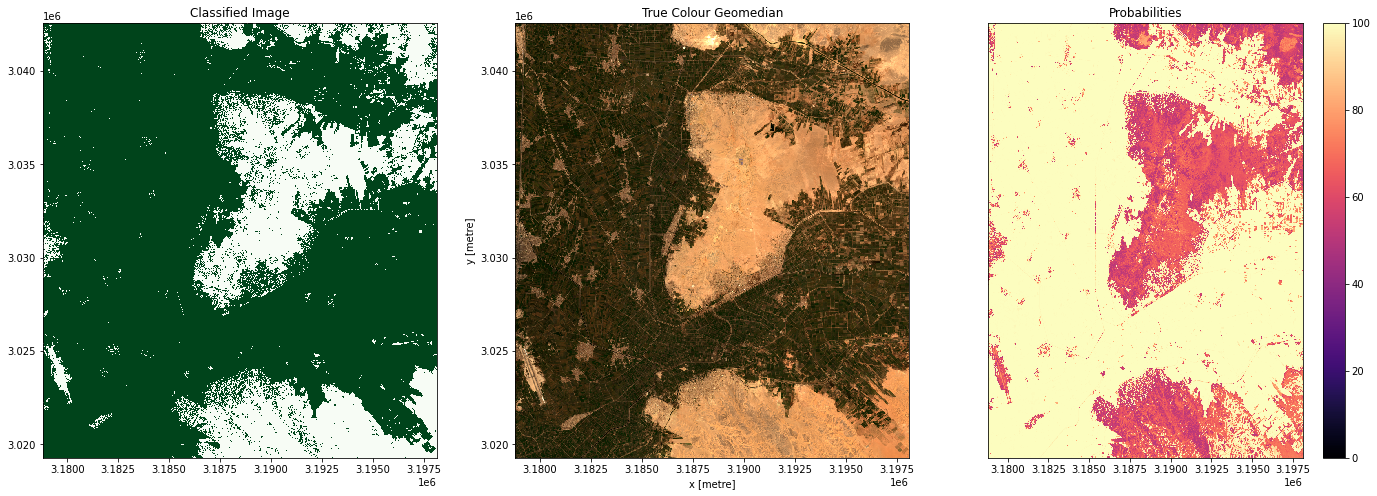

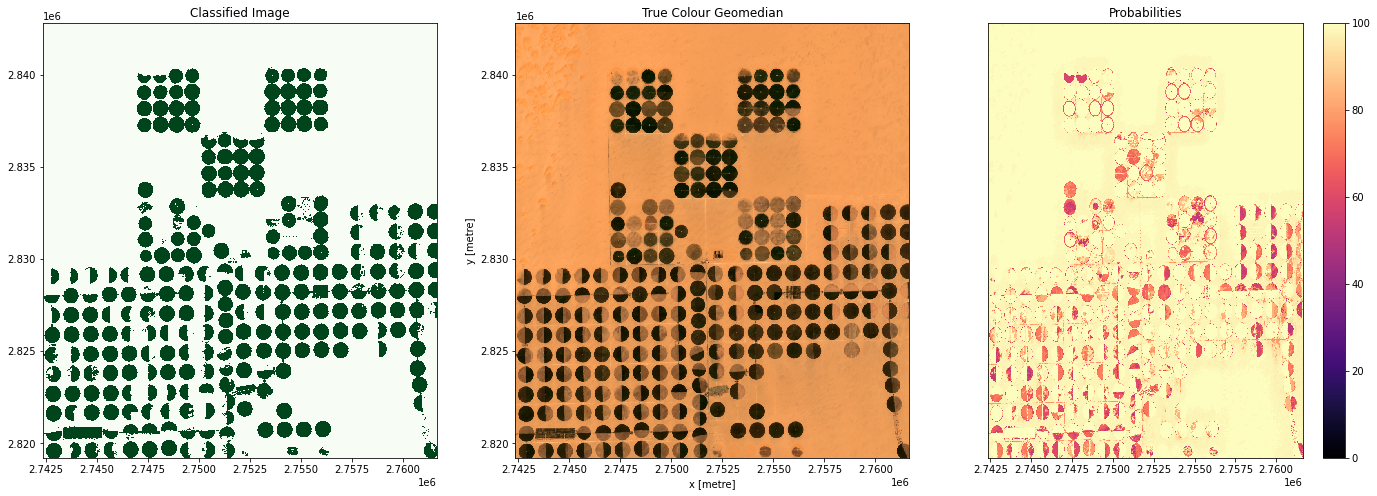

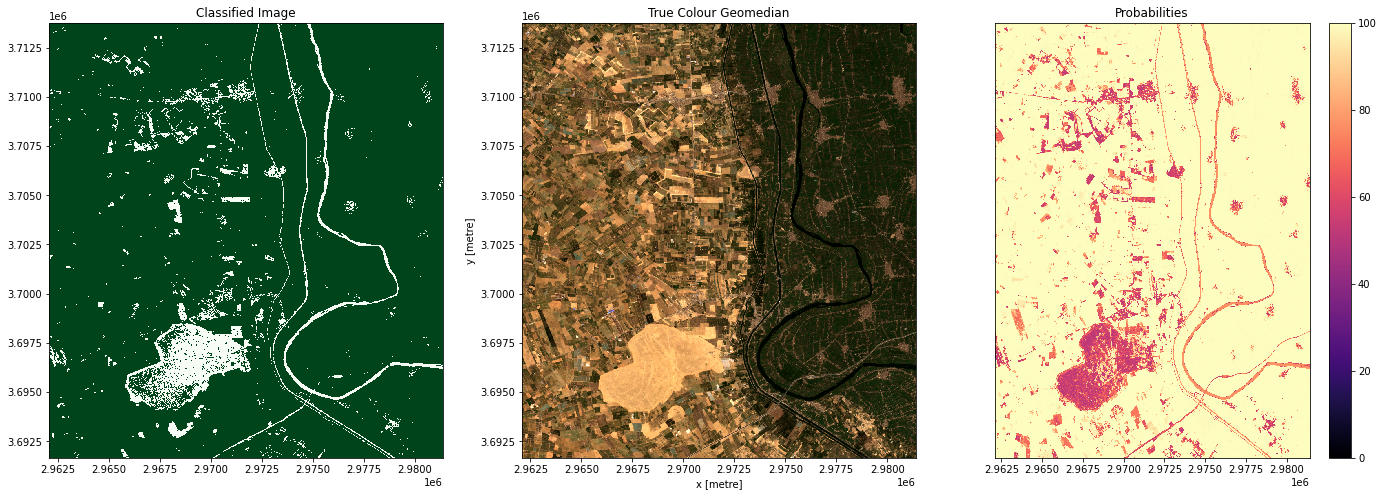

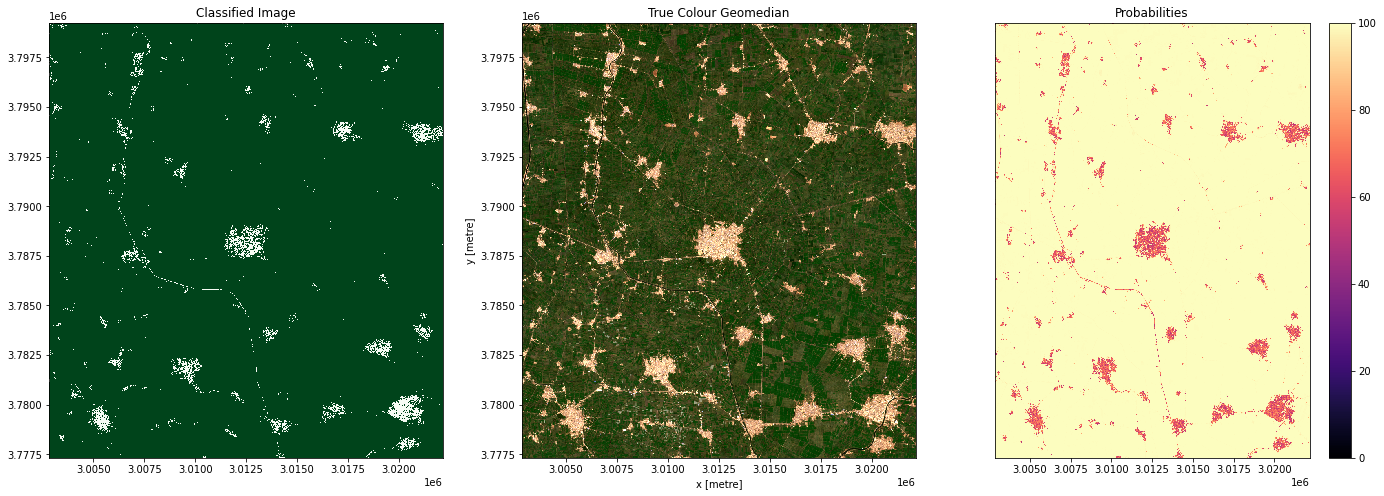

In [11]:
for i in range(0, len(predictions)):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))


    # Plot classified image
    predictions[i].Predictions.plot(ax=axes[0], 
                   cmap='Greens', 
                   add_labels=False, 
                   add_colorbar=False)

    # Plot true colour image
    rgb(predictions[i], bands=['red_S1','green_S1','blue_S1'],
        ax=axes[1], percentile_stretch=(0.01, 0.99))

    predictions[i].Probabilities.plot(ax=axes[2], 
                   cmap='magma',
                   vmin=0,
                   vmax=100,
                   add_labels=False, 
                   add_colorbar=True)

    # Remove axis on right plot
    axes[2].get_yaxis().set_visible(False)

    # Add plot titles
    axes[0].set_title('Classified Image')
    axes[1].set_title('True Colour Geomedian')
    axes[2].set_title('Probabilities');

## Large scale classification

If you're happy with the results of the test locations, then attempt to classify a large region by re-entering a new latitude, longitude and larger buffer size. You may need to adjust the `dask_chunks` size to optimize for the larger region. If you do change the chunk size, then remember to adjust the chunks in the feature layer function above (ie in the default example `two_seasons_gm`)

In [12]:
#clear objects from memory
del ds
del predictions
del predicted

In [34]:
new_lat, new_lon = 29.3037, 30.825#9862 #30.9525, 31.2110 #centred on Faiyum, Egypt
buf_lat, buf_lon = 0.3, 0.5
dask_chunks={'x':1000,'y':1000,'time':1}
name='Nile_Delta'

In [35]:
display_map((new_lon-buf_lon, new_lon+buf_lon), (new_lat+buf_lat, new_lat-buf_lat))

In [ ]:
# generate a datacube query object
query = {
    'x': (new_lon-buf_lon, new_lon+buf_lon),
    'y': (new_lat+buf_lat, new_lat-buf_lat),
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': output_crs,
    'group_by' : 'solar_day',
}

#load data
ds = load_ard(dc=dc,
              products=products,
              dask_chunks=dask_chunks,
              **query)
print(ds)
print('\n')
# calculate features lazily
features = two_seasons_gm(ds)

#predict using the imported model
predicted = predict_xr(model, features, proba=True, persist=True, clean=True, return_input=True).compute()

write_cog(predicted.Predictions, results+'prediction.tif', overwrite=True)
write_cog(predicted.Probabilities, results+'probabilities.tif', overwrite=True)
write_cog(predicted.NDVI_S1, results+'NDVI_S1.tif', overwrite=True)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 142 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 142, x: 4825, y: 3349)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T08:51:54 ... 2019-12-30T08:...
  * y            (y) float64 3.615e+06 3.615e+06 ... 3.548e+06 3.548e+06
  * x            (x) float64 2.926e+06 2.926e+06 ... 3.022e+06 3.022e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir_2       (time, y, x) float32 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='Greens', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
rgb(predicted, bands=['red_S1','green_S1','blue_S1'],
        ax=axes[1], percentile_stretch=(0.01, 0.99))
    
predicted.Probabilities.plot(ax=axes[2], 
               cmap='magma',
               vmin=0,
               vmax=100,
               add_labels=False, 
               add_colorbar=True)

#Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

#Add plot titles
axes[0].set_title('Classified Image')
axes[1].set_title('Probabilities');